- suggestion

- fit 3 models: 
- univariable
- multi w/ mortagage rate (Endogenous), var(p)
- multi w/ motagage rate (Exogenous) and unemployment rate (Exogenous), sarimax

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import sklearn.metrics as skmetrics
import warnings
from statsmodels.tsa.stattools import arma_order_select_ic
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import pmdarima as pm

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

warnings.filterwarnings("ignore")

In [2]:
series = pd.read_csv('zillow-carlifornia.csv',header=0, index_col=0, parse_dates=True, squeeze=True)
series = series.iloc[:-12,:]
series = series.rename(columns={'MedianSoldPrice_AllHomes.California':'MedianSoldPrice_AllHomes_California'})
series

,MedianSoldPrice_AllHomes_California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0


In [3]:
series_target = series[['MedianSoldPrice_AllHomes_California']].copy()
series_target

,MedianSoldPrice_AllHomes_California
Date,
2008-02-29,470000.0
2008-03-31,441000.0
2008-04-30,460000.0
2008-05-31,429000.0
2008-06-30,437500.0
...,...
2015-08-31,475000.0
2015-09-30,470000.0
2015-10-31,470000.0


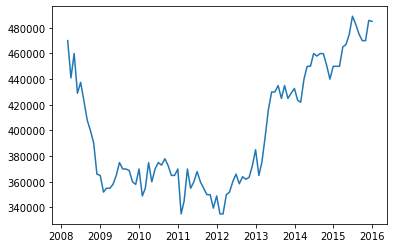

In [4]:
from matplotlib import pyplot
pyplot.plot(series_target)
pyplot.show()

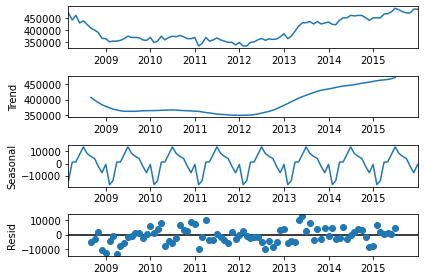

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series_target, model='addictive',freq=12)
result.plot()
plt.show()

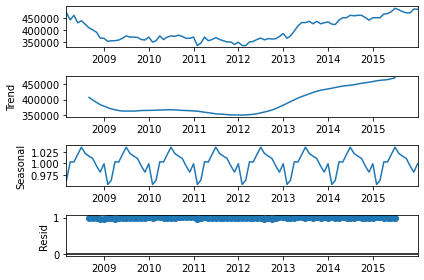

In [6]:
result = seasonal_decompose(series_target, model='multiplicative',freq=12)
result.plot()
plt.show()

In [7]:
# define all the functions we will need 

# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing once: interval=1
#trend differencing twice: d1=diff(data, interval=1); d2=diff(d1 interval=1)
#seasonal differencing: interval=m

#Define ADF test
#Perform from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#[OPTIONAL]grid order search based on BIC
#auto-arima order selection in pmdarima
#if the function doesn't work, you can write one yourself: 

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for Q in Q_values:
                        order=(p,d,q)
                        seasonal_order=(P,D,Q,m)
#                         try:
                        res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                        bic=res.bic
                        if bic < best_score:
                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
#                         except:
#                             continue
    print((best_score, best_order, best_seasonal_order))
    

# define evaluation metrics for model selection based on one-step forward cross validation
def evaluate_sarima_model(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.67)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return rmse, mae, mape

def evaluate_sarima_model_80(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
#     mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
#     mape = np.mean(np.abs(test-predictions)/test)
    return rmse

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.088139
p-value                         0.027443
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


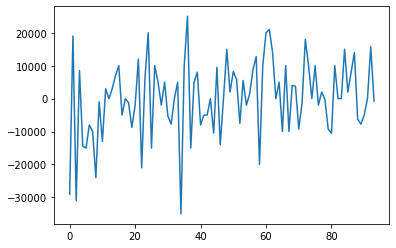

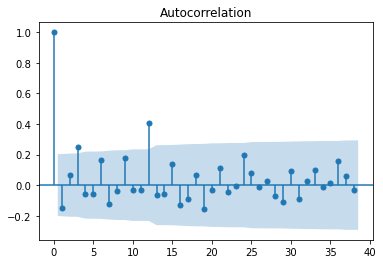

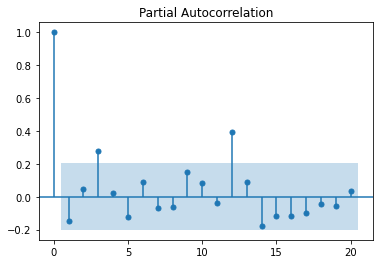

In [8]:
# fit a trend only model d=1
d1 = diff(series_target.MedianSoldPrice_AllHomes_California, 1)
adf_test(d1)
plt.plot(d1)
plot_acf(d1,lags=38) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.390432e+00
p-value                        8.027576e-11
#Lags Used                     1.000000e+01
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


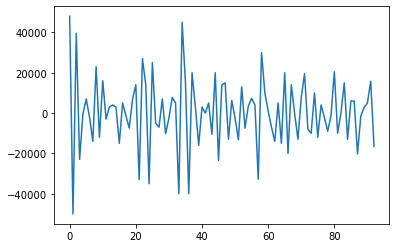

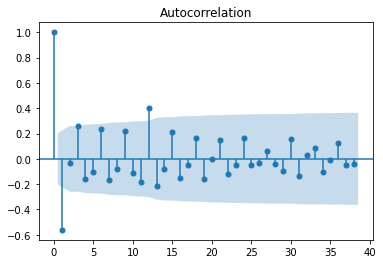

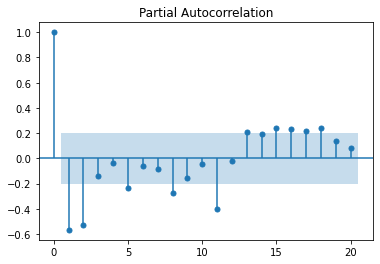

In [9]:
# fit a trend only model d=2
d2 = diff(d1, 1)
adf_test(d2)
plt.plot(d2)
plot_acf(d2,lags=38) 
plt.show()
plot_pacf(d2,lags=20) 
plt.show()

In [10]:
arma_order_select_ic(d1,max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  2033.963390  2036.630234  2038.201850  2038.727602  2042.965276
 1  2036.256559  2041.742188  2045.029117  2043.015486  2046.379687
 2  2040.525869  2044.825090  2059.174906  2043.252734  2050.026017
 3  2037.595611  2042.138257  2058.396258  2045.331928  2058.785280
 4  2042.137845  2047.129999          NaN          NaN  2063.850476,
 'bic_min_order': (0, 0)}

In [11]:
arma_order_select_ic(d2,max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  2087.961822  2016.294021  2016.841839  2019.669602  2021.355709
 1  2053.268703  2016.484160  2023.931164  2025.907115  2025.332265
 2  2027.415767  2020.979061  2024.497702  2019.411054  2023.938432
 3  2029.951874  2033.510407  2024.738814          NaN  2028.441044
 4  2034.266555  2024.635003  2027.482973          NaN          NaN,
 'bic_min_order': (0, 1)}

In [12]:
bic_sarima(series_target.MedianSoldPrice_AllHomes_California, p_values=range(4),d_values=range(3),q_values=range(4),
           P_values=range(3),Q_values=range(3),m=12, D=1)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02660D+01    |proj g|=  6.53344D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.533D-07   1.027D+01
  F =   10.266046239329270     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.115E+01  -gs= 5.939E-01 BFGS update SKIPPED

At iterate    5    f=  1.22663D+01    |proj g|=  1.12246D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7    138      4     3     0   9.430D+04   1.222D+01
  F =   12.221945709685654     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76498D+00    |proj g|=  6.28670D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47786D+01    |proj g|=  4.10775D-05


 This problem is unconstrained.


  ys=-6.842E+01  -gs= 5.696E-01 BFGS update SKIPPED
  ys=-2.771E+01  -gs= 5.977E-01 BFGS update SKIPPED

At iterate    5    f=  1.29310D+01    |proj g|=  4.21012D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7    107      3     2     0   3.728D+03   1.293D+01
  F =   12.930794852080068     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29540D+00    |proj g|=  5.28901D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08057D+00    |proj g|=  1.54033D+01

At iterate    5    f=  7.30019D+00    |proj g|=  1.83617D-02

At iterate   10    f=  7.29915D+00    |proj g|=  2.20076D-02

At iterate   15    f=  7.29873D+00    |proj g|=  2.06010D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   2.883D-06   7.299D+00
  F =   7.2987298826973674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.


  ys=-4.402E+01  -gs= 6.023E-01 BFGS update SKIPPED
  ys=-3.866E+01  -gs= 6.012E-01 BFGS update SKIPPED
  ys=-3.921E+01  -gs= 6.013E-01 BFGS update SKIPPED
  ys=-2.411E+01  -gs= 5.958E-01 BFGS update SKIPPED

At iterate    5    f=  1.23219D+01    |proj g|=  3.24394D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7    108      6     4     0   1.215D+04   1.129D+01
  F =   11.294143800734345     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02737D+01    |proj g|=  4.93372D+00

At iterate    5    f=  9.89287D+00    |proj g|=  4.86821D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61710D+01    |proj g|=  1.92227D-05
  ys=-2.864E+01  -gs= 5.880E-01 BFGS update SKIPPED
  ys=-3.054E+01  -gs= 5.887E-01 BFGS update SKIPPED
  ys=-1.393E+02  -gs= 5.974E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.26033D+01    |proj g|=  6.76965D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6    131      4     3     0   6.770D+03   1.260D+01
  F =   12.603338135850574     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57111D+00    |proj g|=  2.32774D-01

At iterate    5    f=  8.55690D+00    |proj g|=  8.99783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.31516D+00    |proj g|=  8.37333D-03

At iterate   15    f=  8.31510D+00    |proj g|=  1.93308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   1.486D-05   8.315D+00
  F =   8.3151024177295767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48330D+01    |proj g|=  1.10731D-05


 This problem is unconstrained.


  ys=-8.314E+05  -gs= 6.258E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     65      3     1     0   1.771D+05   2.326D+01
  F =   23.262903108197765     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13880D+00    |proj g|=  1.96177D-01

At iterate    5    f=  7.12554D+00    |proj g|=  1.27061D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  7.12448D+00    |proj g|=  2.70048D-02

At iterate   15    f=  7.12423D+00    |proj g|=  3.42944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   1.179D-05   7.124D+00
  F =   7.1242272730676692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.96078D+00    |proj g|=  6.68817D+00


 This problem is unconstrained.



At iterate    5    f=  7.14311D+00    |proj g|=  1.31508D-01

At iterate   10    f=  7.12445D+00    |proj g|=  2.20065D-03

At iterate   15    f=  7.12436D+00    |proj g|=  2.82983D-02

At iterate   20    f=  7.12413D+00    |proj g|=  6.59472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   1.424D-05   7.124D+00
  F =   7.1241282603307798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46947D+01    |proj g|=  1.92212D-05
  ys=-3.265E+07  -gs= 3.849E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     33      2     1     0   4.324D+04   2.332D+01
  F =   23.322486167626955     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.97429D+00    |proj g|=  4.25666D+00

At iterate    5    f=  9.55207D+00    |proj g|=  2.18168D-02

At iterate   10    f=  9.55160D+00    |proj g|=  2.01750D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


  ys=-1.320E+01  -gs= 5.653E-01 BFGS update SKIPPED
  ys=-3.955E+01  -gs= 5.809E-01 BFGS update SKIPPED

At iterate    5    f=  1.32484D+01    |proj g|=  2.34128D+04
  ys=-5.527E+01  -gs= 5.832E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7    149      4     3     0   2.035D+04   1.231D+01
  F =   12.305946789061906     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49034D+00    |proj g|=  3.86751D-01

At iterate    5    f=  8.46361D+00    |proj g|=  7.96324D-03

At iterate   10    f=  8.46349D+00    |proj g|=  6.50127D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66748D+00    |proj g|=  9.29620D+00

At iterate    5    f=  8.10808D+00    |proj g|=  2.78660D-02

At iterate   10    f=  8.10472D+00    |proj g|=  2.52053D-03

At iterate   15    f=  8.10463D+00    |proj g|=  6.09471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   4.208D-05   8.105D+00
  F =   8.1046056406028466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43503D+01    |proj g|=  1.12145D-05
  ys=-1.509E+06  -gs= 5.493E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     29      2     1     0   2.622D+05   2.183D+01
  F =   21.831237588686516     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

A


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  7.03931D+00    |proj g|=  1.76649D-02

At iterate   10    f=  7.03870D+00    |proj g|=  2.08655D-03

At iterate   15    f=  7.03864D+00    |proj g|=  1.00248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   3.971D-05   7.039D+00
  F =   7.0386380042880754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74770D+00    |proj g|=  5.32208D+00


 This problem is unconstrained.



At iterate    5    f=  7.06090D+00    |proj g|=  5.96849D-02

At iterate   10    f=  7.03842D+00    |proj g|=  8.65412D-03

At iterate   15    f=  7.03791D+00    |proj g|=  1.73926D-02

At iterate   20    f=  7.03695D+00    |proj g|=  1.52638D-02

At iterate   25    f=  7.03681D+00    |proj g|=  6.35615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   1.540D-05   7.037D+00
  F =   7.0368062206638209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.


  ys=-9.644E+08  -gs= 1.117E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     33      2     1     0   3.075D+05   2.136D+01
  F =   21.360851265826309     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07134D+01    |proj g|=  1.81556D+01

At iterate    5    f=  9.46752D+00    |proj g|=  3.34508D-01

At iterate   10    f=  9.41173D+00    |proj g|=  5.00481D-02

At iterate   15    f=  9.40892D+00    |proj g|=  1.01133D-03

       

 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52178D+01    |proj g|=  1.96973D-05
  ys=-6.162E+01  -gs= 5.736E-01 BFGS update SKIPPED
  ys=-2.354E+01  -gs= 5.652E-01 BFGS update SKIPPED

At iterate    5    f=  9.90482D+00    |proj g|=  2.69669D+05
  ys=-6.138E+00  -gs= 4.841E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6    111      3     3     0   2.697D+05   9.905D+00
  F =   9.9048227470890673     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59044D+00    |proj g|=  4.80632D+00

At iterate    5    f=  8.45129D+00    |proj g|=  4.92922D-02

At iterate   10    f=  8.45086D+00    |proj g|=  1.14623D-02

At iterate   15    f=  8.45078D+00    |proj g|=  8.60393D-05

       


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15053D+00    |proj g|=  7.41957D+00

At iterate    5    f=  7.99554D+00    |proj g|=  2.05314D-01

At iterate   10    f=  7.97760D+00    |proj g|=  2.40959D-02

At iterate   15    f=  7.97746D+00    |proj g|=  2.60126D-03

At iterate   20    f=  7.97741D+00    |proj g|=  5.98659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   1.919D-05   7.977D+00
  F =   7.9774124579333003     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39268D+01    |proj g|=  2.50171D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     53      2     0     0   1.771D+05   2.177D+01
  F =   21.772350877380148     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04265D+00    |proj g|=  1.30915D-01

At iterate    5    f=  7.03397D+00    |proj g|=  3.84477D-02

At iterate   10    f=  7.03061D+00    |proj g|=  1.95224D-02

At iterate   15    f=  7.03013D+00    |proj g|=  5.53388D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  7.03215D+00    |proj g|=  2.19749D-02

At iterate   15    f=  7.03029D+00    |proj g|=  1.21272D-02

At iterate   20    f=  7.03002D+00    |proj g|=  2.10081D-03

At iterate   25    f=  7.02976D+00    |proj g|=  1.88476D-02

At iterate   30    f=  7.02971D+00    |proj g|=  4.76462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     36      1     0     0   4.632D-05   7.030D+00
  F =   7.0297145380451695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.


  ys=-9.627E+08  -gs= 1.076E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     31      2     1     0   6.866D+05   1.704D+01
  F =   17.041173139559511     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13414D+00    |proj g|=  6.35065D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56835D+01    |proj g|=  5.42538D-05


 This problem is unconstrained.


  ys=-4.554E+01  -gs= 5.923E-01 BFGS update SKIPPED
  ys=-3.744E+01  -gs= 5.907E-01 BFGS update SKIPPED

At iterate    5    f=  1.23638D+01    |proj g|=  6.50521D+04
  ys=-2.587E+01  -gs= 5.964E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6    104      3     3     0   6.505D+04   1.236D+01
  F =   12.363849601481911     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81187D+00    |proj g|=  5.07150D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.636E+01  -gs= 5.869E-01 BFGS update SKIPPED
  ys=-2.565E+02  -gs= 5.986E-01 BFGS update SKIPPED
  ys=-2.236E+01  -gs= 5.847E-01 BFGS update SKIPPED
  ys=-2.540E+01  -gs= 5.865E-01 BFGS update SKIPPED

At iterate    5    f=  1.27660D+01    |proj g|=  5.55464D+04
  ys=-1.454E+01  -gs= 5.756E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     84      6     5     0   5.555D+04   1.277D+01
  F =   12.766048894163838     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.41362D+00    |proj g|=  5.33083D-02

At iterate   10    f=  6.41247D+00    |proj g|=  1.45609D-02

At iterate   15    f=  6.41005D+00    |proj g|=  3.33194D-02

At iterate   20    f=  6.40932D+00    |proj g|=  1.33826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   1.338D-05   6.409D+00
  F =   6.4093194006964689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46438D+01    |proj g|=  8.45926D-05
  ys=-1.613E+01  -gs= 5.792E-01 BFGS update SKIPPED
  ys=-1.768E+02  -gs= 5.980E-01 BFGS update SKIPPED
  ys=-2.204E+01  -gs= 5.845E-01 BFGS update SKIPPED
  ys=-8.219E+01  -gs= 5.957E-01 BFGS update SKIPPED

At iterate    5    f=  1.16619D+01    |proj g|=  9.04308D+04
  ys=-1.265E+01  -gs= 5.696E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     87      6   


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51709D+01    |proj g|=  5.92181D-05
  ys=-1.474E+01  -gs= 5.676E-01 BFGS update SKIPPED
  ys=-3.305E+01  -gs= 5.793E-01 BFGS update SKIPPED
  ys=-1.910E+01  -gs= 5.723E-01 BFGS update SKIPPED


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.33135D+01    |proj g|=  4.66625D+04
  ys=-1.011E+02  -gs= 5.859E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6    112      4     4     0   4.666D+04   1.331D+01
  F =   13.313528109665985     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79199D+00    |proj g|=  1.55524D-01

At iterate    5    f=  7.76914D+00    |proj g|=  1.19617D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


  ys=-1.474E+01  -gs= 5.676E-01 BFGS update SKIPPED
  ys=-3.967E+01  -gs= 5.810E-01 BFGS update SKIPPED

At iterate    5    f=  1.36592D+01    |proj g|=  1.21565D+04
  ys=-2.014E+01  -gs= 5.731E-01 BFGS update SKIPPED
  ys=-3.895E+00  -gs= 5.501E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7    117      3     4     0   9.822D+04   1.171D+01
  F =   11.706155077456993     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40256D+00    |proj g|=  1.19333D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.38817D+00    |proj g|=  2.13285D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     11      1     0     0   1.978D-05   6.388D+00
  F =   6.3881742437368612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59122D+00    |proj g|=  1.64529D+00


 This problem is unconstrained.



At iterate    5    f=  6.40440D+00    |proj g|=  3.99965D-02

At iterate   10    f=  6.39965D+00    |proj g|=  8.34635D-02

At iterate   15    f=  6.38736D+00    |proj g|=  4.66703D-03

At iterate   20    f=  6.38735D+00    |proj g|=  1.99525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   1.995D-05   6.387D+00
  F =   6.3873511067267899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


  ys=-1.474E+01  -gs= 5.676E-01 BFGS update SKIPPED
  ys=-3.897E+01  -gs= 5.808E-01 BFGS update SKIPPED
  ys=-7.614E+01  -gs= 5.850E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.23866D+01    |proj g|=  7.63778D+04
  ys=-3.622E+01  -gs= 5.790E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6    114      4     4     0   7.638D+04   1.239D+01
  F =   12.386608715165446     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84923D+00    |proj g|=  1.51066D-01

At iterate    5    f=  8.83250D+00    |proj g|=  2.12307D-04

           * * *



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47113D+01    |proj g|=  5.91779D-05


 This problem is unconstrained.


  ys=-2.129E+01  -gs= 5.640E-01 BFGS update SKIPPED
  ys=-1.531E+01  -gs= 5.586E-01 BFGS update SKIPPED
  ys=-2.555E+01  -gs= 5.664E-01 BFGS update SKIPPED
  ys=-2.179E+01  -gs= 5.643E-01 BFGS update SKIPPED

At iterate    5    f=  1.26505D+01    |proj g|=  4.40491D+04
  ys=-2.130E+02  -gs= 5.773E-01 BFGS update SKIPPED

At iterate   10    f=  1.23251D+01    |proj g|=  3.07850D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     83      6     5     0   1.776D-10   1.233D+01
  F =   12.325080132395161     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.41121D+00    |proj g|=  4.32361D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.427D-05   7.411D+00
  F =   7.4111954089501664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45469D+01    |proj g|=  5.91815D-05


 This problem is unconstrained.


  ys=-2.129E+01  -gs= 5.640E-01 BFGS update SKIPPED
  ys=-1.530E+01  -gs= 5.586E-01 BFGS update SKIPPED
  ys=-2.347E+01  -gs= 5.653E-01 BFGS update SKIPPED
  ys=-5.638E+01  -gs= 5.731E-01 BFGS update SKIPPED

At iterate    5    f=  1.22289D+01    |proj g|=  5.91468D+04
  ys=-1.233E+02  -gs= 5.760E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     79      6     5     0   5.915D+04   1.223D+01
  F =   12.228898751950862     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40316D+00    |proj g|=  1.76859D-01

At iterate    5    f=  6.37751D+00    |proj g|=  4.58633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  6.40119D+00    |proj g|=  2.10791D-02

At iterate   10    f=  6.39474D+00    |proj g|=  1.15949D-01

At iterate   15    f=  6.37640D+00    |proj g|=  9.77290D-03

At iterate   20    f=  6.37621D+00    |proj g|=  2.38466D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   2.040D-05   6.376D+00
  F =   6.3762105108418972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


  ys=-2.129E+01  -gs= 5.640E-01 BFGS update SKIPPED
  ys=-1.532E+01  -gs= 5.586E-01 BFGS update SKIPPED
  ys=-2.751E+01  -gs= 5.673E-01 BFGS update SKIPPED

At iterate    5    f=  1.28100D+01    |proj g|=  1.57793D+04
  ys=-2.222E+01  -gs= 5.645E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7    109      5     4     0   1.664D+05   1.028D+01
  F =   10.284139776681808     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74909D+00    |proj g|=  2.95491D-01

At iterate    5    f=  8.70424D+00    |proj g|=  5.47198D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.30635D+00    |proj g|=  4.65736D-03

At iterate   10    f=  7.30632D+00    |proj g|=  1.03065D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.031D-05   7.306D+00
  F =   7.3063171625249916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42415D+01    |proj g|=  6.02405D-05


 This problem is unconstrained.


  ys=-2.126E+01  -gs= 5.540E-01 BFGS update SKIPPED
  ys=-5.913E+01  -gs= 5.631E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.19504D+01    |proj g|=  2.69596D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6    127      3     2     0   2.696D+04   1.195D+01
  F =   11.950353941619902     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77758D+00    |proj g|=  1.28398D-01

At iterate    5    f=  7.75546D+00    |proj g|=  2.36619D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.29701D+00    |proj g|=  5.58236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   1.483D-05   7.297D+00
  F =   7.2969479248864806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40801D+01    |proj g|=  6.02434D-05


 This problem is unconstrained.


  ys=-2.049E+01  -gs= 5.535E-01 BFGS update SKIPPED
  ys=-7.658E+00  -gs= 5.676E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     96      2     2     0   1.688D+04   1.185D+01
  F =   11.848918250077483     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39230D+00    |proj g|=  1.39456D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.36451D+00    |proj g|=  2.97804D-02

At iterate   10    f=  6.36417D+00    |proj g|=  8.68098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     19      1     0     0   2.946D-05   6.364D+00
  F =   6.3641726092400139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64826D+00    |proj g|=  2.25747D+00

At iterate    5    f=  6.39564D+00    |proj g|=  1.13549D-02


 This problem is unconstrained.



At iterate   10    f=  6.38999D+00    |proj g|=  1.38989D-01

At iterate   15    f=  6.36332D+00    |proj g|=  4.22319D-02

At iterate   20    f=  6.36264D+00    |proj g|=  1.58651D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     27      1     0     0   1.587D-04   6.363D+00
  F =   6.3626354934533946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35090D+01    |proj g|=  6.02430D-05


 This problem is unconstrained.


  ys=-2.060E+01  -gs= 5.535E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      4     86      2     1     0   6.344D+03   1.134D+01
  F =   11.335841298730967     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36918D+00    |proj g|=  4.56719D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4     88      3     1     0   5.302D+00   2.467D+01
  F =   24.668701077263776     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01492D+00    |proj g|=  4.95319D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50739D+01    |proj g|=  4.00672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     10      1     0     0   3.172D-04   2.507D+01
  F =   25.073897138860769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55122D+00    |proj g|=  5.19735D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   5.197D-06   6.551D+00
  F =   6.5512159998353621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.5

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   1.550D-05   6.550D+00
  F =   6.5497891381745719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51426D+01    |proj g|=  7.31639D-05


 This problem is unconstrained.


  ys=-2.356E+01  -gs= 5.754E-01 BFGS update SKIPPED
  ys=-6.587E+01  -gs= 5.843E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     92      2     2     0   1.816D+04   1.366D+01
  F =   13.655205462383845     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87647D+00    |proj g|=  1.06089D+01

At iterate    5    f=  8.84132D+00    |proj g|=  3.17508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41210D+01    |proj g|=  1.03021D+01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-8.499E-13  -gs= 4.600E-13 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.680E+07  -gs= 3.830E+02 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5    116      4     2     0   2.490D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91357D+00    |proj g|=  3.08233D+00

At iterate    5    f=  7.71926D+00    |proj g|=  3.90667D-01

At iterate   10    f=  7.69603D+00    |proj g|=  1.85614D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46993D+01    |proj g|=  1.30631D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     12      1     0     0   1.224D-03   2.470D+01
  F =   24.699299848414867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35181D+00    |proj g|=  1.67948D+01

At iterate    5    f=  6.34091D+00    |proj g|=  1.40250D-01

At iterate   10    f=  6.33777D+00    |proj g|=  1.25304D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   10    f=  6.33736D+00    |proj g|=  1.13995D-02

At iterate   15    f=  6.33725D+00    |proj g|=  6.97042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   1.094D-05   6.337D+00
  F =   6.3372297338890196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48337D+01    |proj g|=  5.64189D-05


 This problem is unconstrained.


  ys=-1.498E+01  -gs= 5.582E-01 BFGS update SKIPPED

At iterate    5    f=  1.20730D+01    |proj g|=  5.62079D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     97      2     1     0   5.621D+04   1.207D+01
  F =   12.073004244879751     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05515D+01    |proj g|=  6.93010D+00

At iterate    5    f=  8.72951D+00    |proj g|=  6.27685D-02

At iterate   10    f=  8.72818D+00    |proj g|=  1.22994D+00

At iterate   15    f=  8.72668D+00    |proj g|=  1.20901D-02

       

 This problem is unconstrained.


  ys=-3.365E+05  -gs= 2.632E+01 BFGS update SKIPPED
  ys=-4.708E+00  -gs= 2.047E+02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     48      3     2     0   1.772D+06   6.133D+00
  F =   6.1330525040981874     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71239D+00    |proj g|=  7.45566D-01

At iterate    5    f=  7.69434D+00    |proj g|=  6.24505D-02

At iterate   10    f=  7.69


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     39      1     0     0   7.367D-04   7.694D+00
  F =   7.6941159698063144     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09177D+00    |proj g|=  1.08872D+01

At iterate    5    f=  7.35542D+00    |proj g|=  1.95843D-01

At iterate   10    f=  7.35406D+00    |proj g|=  1.89559D-02

At iterate   15    f=  7.35303D+00    |proj g|=  1.10381D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     82      2     0     0   2.252D-04   7.353D+00
  F =   7.3526224407319383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42445D+01    |proj g|=  1.15960D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     57      2     0     0   4.550D+04   3.157D+00
  F =   3.1573337084520166     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72005D+00    |proj g|=  6.61802D+00

At iterate    5    f=  6.39507D+00    |proj g|=  4.16913D-01

At iterate   10    f=  6.36181D+00    |proj g|=  4.24621D-02

At iterate   15    f=  6.35631D+00    |proj g|=  2.91438D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43559D+00    |proj g|=  1.53267D+01
  ys=-1.039E-02  -gs= 1.760E-01 BFGS update SKIPPED

At iterate    5    f=  6.38118D+00    |proj g|=  6.46173D-01

At iterate   10    f=  6.31504D+00    |proj g|=  5.20164D-02

At iterate   15    f=  6.30684D+00    |proj g|=  1.73238D-01

At iterate   20    f=  6.30346D+00    |proj g|=  6.64474D-03

At iterate   25    f=  6.30343D+00    |proj g|=  2.56285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.607E+06  -gs= 9.024E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     63      3     1     0   2.439D+06   4.605D-01
  F =  0.46047511828913545     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28366D+00    |proj g|=  9.70480D+00

At iterate    5    f=  8.66710D+00    |proj g|=  3.64500D-01

At iterate   10    f=  8.65991D+00    |proj g|=  5.37038D-02

At iterate   15    f=  8.65821D+00    |proj g|=  4.12509D-02

       

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32299D+01    |proj g|=  2.96023D+01

At iterate    5    f=  2.32297D+01    |proj g|=  3.01284D+01
  ys=-6.771E-16  -gs= 9.712E-16 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     85      2     1     0   5.248D+01   2.323D+01
  F =   23.229307645134501     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70922D+00    |proj g|=  9.83356D-01

At iterate    5    f=  7.66786D+00    |proj g|=  1.00824D-01

At iterate   10    f=  7.66623D+00    |proj g|=  5.23822D-02

At iterate   15    f=  7.66587D+00    |proj g|=  1.85062D-02

       

 This problem is unconstrained.



At iterate   10    f=  7.21143D+00    |proj g|=  2.31110D-01

At iterate   15    f=  7.20851D+00    |proj g|=  1.25708D-01

At iterate   20    f=  7.20362D+00    |proj g|=  2.41249D-02

At iterate   25    f=  7.20331D+00    |proj g|=  1.13057D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     36      1     0     0   1.788D-04   7.203D+00
  F =   7.2032947419893345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3     61      3     1     0   2.419D+06   4.894D-01
  F =  0.48944870443134575     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41856D+00    |proj g|=  1.90009D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.29548D+00    |proj g|=  1.29376D-01

At iterate   10    f=  6.29351D+00    |proj g|=  3.58450D-02

At iterate   15    f=  6.29328D+00    |proj g|=  1.99949D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   7.020D-04   6.293D+00
  F =   6.2932736770202133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17207D+00    |proj g|=  5.95404D+00

At iterate    5    f=  6.29746D+00    |proj g|=  2.30545D-01

At iterate   10    f=  6.29220D+00    |proj g|=  9.22711D-03

At iterate   15    f=  6.29161D+00    |proj g|=  5.77927D-02

At iterate   20    f=  6.29146D+00    |proj g|=  1.61530D-02

At iterate   25    f=  6.29138D+00    |proj g|=  1.28918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     31      1     0     0   1.887D-04   6.291D+00
  F =   6.291379178001

 This problem is unconstrained.


  ys=-4.825E+01  -gs= 5.516E-01 BFGS update SKIPPED
  ys=-7.785E+01  -gs= 5.540E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.19780D+01    |proj g|=  2.00146D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      8     83      2     2     0   1.776D-09   1.197D+01
  F =   11.968107752135998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22888D+00    |proj g|=  5.32809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-3.493E+02  -gs= 6.095E-01 BFGS update SKIPPED
  ys=-2.675E+01  -gs= 5.972E-01 BFGS update SKIPPED
  ys=-1.050E+02  -gs= 6.070E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     87      3     3     0   6.890D+03   1.465D+01
  F =   14.649175817367306     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86856D+00    |proj g|=  2.49571D-01

At iterate    5    f=  7.81308D+00    |proj g|=  3.72995D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


  ys=-4.058E-01  -gs= 7.603E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     34      2     1     0   5.025D-04   2.389D+01
  F =   23.892297852608845     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62993D+00    |proj g|=  3.95489D-01

At iterate    5    f=  6.42955D+00    |proj g|=  6.08355D-03

At iterate   10    f=  6.42953D+00    |proj g|=  3.68048D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  6.45710D+00    |proj g|=  9.13438D-02

At iterate   10    f=  6.44619D+00    |proj g|=  2.94756D-02

At iterate   15    f=  6.42048D+00    |proj g|=  7.42277D-02

At iterate   20    f=  6.42006D+00    |proj g|=  2.29296D-02

At iterate   25    f=  6.41885D+00    |proj g|=  4.24511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   2.040D-05   6.419D+00
  F =   6.4188489474605506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.


  ys=-3.498E+02  -gs= 6.095E-01 BFGS update SKIPPED
  ys=-3.658E+01  -gs= 6.007E-01 BFGS update SKIPPED

At iterate    5    f=  1.00998D+01    |proj g|=  1.71869D+05
  ys=-2.321E+01  -gs= 5.869E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6    100      3     3     0   1.719D+05   1.010D+01
  F =   10.099801489511654     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11208D+00    |proj g|=  3.35236D-01

At iterate    5    f=  9.10339D+00    |proj g|=  4.81977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


  ys=-2.308E+01  -gs= 5.852E-01 BFGS update SKIPPED
  ys=-2.002E+01  -gs= 5.830E-01 BFGS update SKIPPED

At iterate    5    f=  1.27869D+01    |proj g|=  3.47102D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     63      3     2     0   1.066D-09   1.264D+01
  F =   12.638140653313963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89856D+00    |proj g|=  4.34152D-01

At iterate    5    f=  7.78739D+00    |proj g|=  4.25676D-01

At iterate   10    f=  7.76468D+00    |proj g|=  9.05781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   3.995D-05   7.765D+00
  F =   7.7646523638026839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3     12      1     0     0   8.678D-05   2.414D+01
  F =   24.135011745900417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64247D+00    |proj g|=  4.44156D-01


 This problem is unconstrained.



At iterate    5    f=  6.38496D+00    |proj g|=  4.15529D-02

At iterate   10    f=  6.38432D+00    |proj g|=  7.55099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.858D-05   6.384D+00
  F =   6.3843162294872720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76908D+00    |proj g|=  1.99385D+01

At iterate    5    f=  6.45149D+00    |proj g|=  9.57810D-02

At iterate   10    f=  6.43200D+00    |proj g|=  9.29862D-02

At iterate   15    f=  6.40270D+00    |proj g|=  1.20801D-01

At iterate   20    f=  6.38489D+00    |proj g|=  5.06934D-02

At iterate   25    f=  6.38328D+00    |proj g|=  1.91927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     37      1     0     0   

 This problem is unconstrained.


  ys=-2.308E+01  -gs= 5.852E-01 BFGS update SKIPPED
  ys=-1.965E+01  -gs= 5.827E-01 BFGS update SKIPPED
  ys=-1.120E+02  -gs= 5.968E-01 BFGS update SKIPPED

At iterate    5    f=  1.03662D+01    |proj g|=  1.12607D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6    105      4     3     0   1.126D+05   1.037D+01
  F =   10.366210303237871     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95997D+00    |proj g|=  4.04514D-01

At iterate    5    f=  8.94484D+00    |proj g|=  2.56813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.53740D+00    |proj g|=  9.18553D-02

At iterate   15    f=  7.53188D+00    |proj g|=  8.25131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   5.053D-05   7.532D+00
  F =   7.5318787619174277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50249D+01    |proj g|=  6.05638D-05


 This problem is unconstrained.


  ys=-2.521E+01  -gs= 5.763E-01 BFGS update SKIPPED
  ys=-8.402E+01  -gs= 5.854E-01 BFGS update SKIPPED

At iterate    5    f=  9.85965D+00    |proj g|=  2.96149D+05
  ys=-1.938E+01  -gs= 5.501E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6    106      3     3     0   2.961D+05   9.860D+00
  F =   9.8596533555258805     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89377D+00    |proj g|=  5.02655D-01

At iterate    5    f=  7.77010D+00    |proj g|=  1.27164D-01

At iterate   10    f=  7.75305D+00    |proj g|=  3.98823D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     21      1     0     0   1.214D-05   7.753D+00
  F =   7.7530481161965001     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37104D+01    |proj g|=  6.45979D-05
  ys=-2.706E+07  -gs= 4.200E-02 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     31      2     1     0   2.414D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64243D+00    |proj g|=  4.73094D-01

At iterate    5    f=  6.37872D+00    |proj g|=  2.04108D-01

At iterate   10    f=  6.37448D+00    |proj g|=  9.92557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   2.023D-05   6.374D+00
  F =   6.3744782450867996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92673D+00    |proj g|=  2.12006D+01

At iterate    5    f=  6.45232D+00    |proj g|=  8.97091D-02

At iterate   10    f=  6.43065D+00    |proj g|=  3.02472D-02

At iterate   15    f=  6.39850D+00    |proj g|=  1.50302D-01

At iterate   20    f=  6.37359D+00    |proj g|=  5.59541D-02

At iterate   25    f=  6.37268D+00    |proj g|=  1.49529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     37      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35745D+01    |proj g|=  6.05656D-05
  ys=-2.521E+01  -gs= 5.763E-01 BFGS update SKIPPED
  ys=-1.022E+02  -gs= 5.861E-01 BFGS update SKIPPED
  ys=-2.117E+01  -gs= 5.739E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  9.35181D+00    |proj g|=  2.00351D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6    115      3     3     0   2.004D+05   9.352D+00
  F =   9.3518062656088041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85345D+00    |proj g|=  5.62337D-01

At iterate    5    f=  8.80455D+00    |proj g|=  1.17946D-01

At iterate   10    f=  8.80148D+00    |proj g|=  2.23906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   3.739D-06   8.801D+00
  F =   8.8014776345923043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45553D+01    |proj g|=  6.18620D-05
  ys=-2.032E+01  -gs= 5.633E-01 BFGS update SKIPPED

At iterate    5    f=  1.05412D+01    |proj g|=  2.03793D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6    101      2     1     0   2.038D+05   1.054D+01
  F =   10.541180441538016     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.96289D+00    |proj g|=  1.00096D+00

At iterate    5    f=  7.76220D+00    |proj g|=  2.59861D-01

At iterate   10    f=  7.74746D+00    |proj g|=  6.72769D-02

At iterate   15    f=  7.74725D+00    |proj g|=  5.83792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   3.195D-05   7.747D+00
  F =   7.7472515761917027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64998D+01    |proj g|=  6.28981D+01

At iterate    5    f=  7.44273D+00    |proj g|=  7.55406D-02

At iterate   10    f=  7.41118D+00    |proj g|=  1.16296D-01

At iterate   15    f=  7.40338D+00    |proj g|=  8.84434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     19      1     0     0   1.191D-04   7.403D+00
  F =   7.4033774165296720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32643D+01    |proj g|=  6.48903D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      3     15      1     0     0   8.722D+05   2.003D+01
  F =   20.028702086870965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66899D+00    |proj g|=  5.29185D-01

At iterate    5    f=  6.37871D+00    |proj g|=  1.43462D-01

At iterate   10    f=  6.35993D+00    |proj g|=  2.45058D-02

At iterate   15    f=  6.35943D+00    |proj g|=  5.38411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     29      1     0     0   5.384D-05   6.359D+00
  F =   6.3594346131428665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00355D+01    |proj g|=  2.94658D+01


 This problem is unconstrained.



At iterate    5    f=  6.44178D+00    |proj g|=  1.01345D-01

At iterate   10    f=  6.41895D+00    |proj g|=  6.62450D-02

At iterate   15    f=  6.40931D+00    |proj g|=  3.04087D-02

At iterate   20    f=  6.38849D+00    |proj g|=  1.65274D-01

At iterate   25    f=  6.36152D+00    |proj g|=  1.09094D-01

At iterate   30    f=  6.35761D+00    |proj g|=  6.54726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     42      1     0     0   8.784D-05   6.358D+00
  F =   6.3575914332829360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31308D+01    |proj g|=  6.18666D-05
  ys=-1.247E+02  -gs= 5.763E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.06667D+01    |proj g|=  1.91247D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6    108      3     1     0   1.912D+04   1.067D+01
  F =   10.666727726406839     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11750D+00    |proj g|=  4.75566D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.756D-06   9.118D+00
  F =   9.1175042848705967     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.6

 This problem is unconstrained.


  ys=-2.577E+02  -gs= 5.986E-01 BFGS update SKIPPED
  ys=-2.161E+01  -gs= 5.842E-01 BFGS update SKIPPED
  ys=-1.191E+02  -gs= 5.970E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     87      3     3     0   9.841D+03   1.432D+01
  F =   14.322375220769604     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67010D+00    |proj g|=  8.21866D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70200D+00    |proj g|=  2.28751D-01

At iterate    5    f=  7.66062D+00    |proj g|=  1.08831D-02

At iterate   10    f=  7.66023D+00    |proj g|=  1.80132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   2.000D-05   7.660D+00
  F =   7.6602320055221798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54912D+01    |proj g|=  5.62746D-05
  ys=-2.578E+02  -gs= 5.986E-01 BFGS update SKIPPED
  ys=-1.184E+02  -gs= 5.970E-01 BFGS update SKIPPED

At iterate    5    f=  1.24939D+01    |proj g|=  2.01166D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     99      3     2     0   2.012D+04   1.249D+01
  F =   12.493918406767863     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29836D+00    |proj g|=  7.08905D-02

At iterate    5    f=  6.29030D+00    |proj g|=  2.35842D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   2.358D-05   6.290D+00
  F =   6.2902953055672421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46076D+00    |proj g|=  1.45225D+00

At iterate    5    f=  6.30189D+00    |proj g|=  2.65949D-02

At iterate   10    f=  6.30103D+00    |proj g|=  3.70785D-02

At iterate   15    f=  6.29915D+00    |proj g|=  6.50452D-03

At iterate   20    f=  6.29911D+00    |proj g|=  2.19556D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   2.196D-05   6.299D+00
  F =   6.2991055817766330     

CONVERG

 This problem is unconstrained.


  ys=-2.578E+02  -gs= 5.986E-01 BFGS update SKIPPED
  ys=-6.131E+01  -gs= 5.942E-01 BFGS update SKIPPED

At iterate    5    f=  1.07450D+01    |proj g|=  1.63265D+05
  ys=-4.143E+00  -gs= 5.243E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6    101      3     3     0   1.633D+05   1.075D+01
  F =   10.745026304265258     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98534D+00    |proj g|=  3.51851D-01

At iterate    5    f=  8.95756D+00    |proj g|=  5.86134D-02

At iterate   10    f=  8.93445D+00    |proj g|=  1.12515D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.53014D+00    |proj g|=  1.76307D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   1.481D-05   7.530D+00
  F =   7.5301372981792314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51695D+01    |proj g|=  5.93534D-05


 This problem is unconstrained.


  ys=-1.538E+01  -gs= 5.685E-01 BFGS update SKIPPED
  ys=-3.247E+01  -gs= 5.791E-01 BFGS update SKIPPED

At iterate    5    f=  1.42471D+01    |proj g|=  6.26949D+03
  ys=-1.921E+01  -gs= 5.724E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     98      3     3     0   6.269D+03   1.425D+01
  F =   14.247120343049856     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66764D+00    |proj g|=  5.29017D-02

At iterate    5    f=  7.65294D+00    |proj g|=  4.78534D-02

At iterate   10    f=  7.64972D+00    |proj g|=  1.79034D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56988D+00    |proj g|=  2.22918D-01

At iterate    5    f=  7.52658D+00    |proj g|=  1.03947D-02

At iterate   10    f=  7.52543D+00    |proj g|=  2.98501D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   3.820D-05   7.525D+00
  F =   7.5254312834166539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


  ys=-1.538E+01  -gs= 5.685E-01 BFGS update SKIPPED

At iterate    5    f=  1.08178D+01    |proj g|=  1.99302D+05
  ys=-4.914E-02  -gs= 7.825E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7    113      3     2     0   3.244D+05   9.544D+00
  F =   9.5435055830055138     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29095D+00    |proj g|=  4.94563D-02


 This problem is unconstrained.



At iterate    5    f=  6.28540D+00    |proj g|=  1.52120D-02

At iterate   10    f=  6.26939D+00    |proj g|=  5.62735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   2.097D-05   6.269D+00
  F =   6.2692875537724184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47914D+00    |proj g|=  1.66101D+00


 This problem is unconstrained.



At iterate    5    f=  6.29297D+00    |proj g|=  3.12885D-02

At iterate   10    f=  6.29052D+00    |proj g|=  1.87219D-02

At iterate   15    f=  6.27067D+00    |proj g|=  3.37505D-02

At iterate   20    f=  6.26770D+00    |proj g|=  4.05408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     29      1     0     0   2.714D-05   6.268D+00
  F =   6.2677035807881616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


  ys=-1.538E+01  -gs= 5.685E-01 BFGS update SKIPPED
  ys=-2.569E+01  -gs= 5.765E-01 BFGS update SKIPPED

At iterate    5    f=  1.18354D+01    |proj g|=  9.56282D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      8     69      2     2     0   6.010D-06   1.179D+01
  F =   11.789501651555643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85940D+00    |proj g|=  7.47703D-01

At iterate    5    f=  8.83144D+00    |proj g|=  3.87362D-02

At iterate   10    f=  8.82955D+00    |proj g|=  4.46455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   8.281D-06   8.830D+00
  F =   8.8295529430903610     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47063D+01    |proj g|=  5.96934D-05
  ys=-2.797E+01  -gs= 5.674E-01 BFGS update SKIPPED
  ys=-5.151E+01  -gs= 5.726E-01 BFGS update SKIPPED
  ys=-9.436E+01  -gs= 5.754E-01 BFGS update SKIPPED

At iterate    5    f=  1.08277D+01    |proj g|=  1.92008D+05
  ys=-6.826E-02  -gs= 7.579E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7    111      4     4     0   3.649D+05   9.076D+00
  F =   9.0758667056995996     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68536D+00    |proj g|=  3.99248D-01

At iterate    5    f=  7.64874D+00    |proj g|=  3.13281D-03

At iterate   10    f=  7.64861D+00    |proj g|=  1.84543D-02

At iterate   15    f=  7.64745D+00    |proj g|=  1.02830D-02

At iterate   20    f=  7.64737D+00    |proj g|=  1.04588D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   1.046D-05   7.647D+00
  F =   7.6473734301389591     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47372D+00    |proj g|=  3.92492D-01

At iterate    5    f=  7.41119D+00    |proj g|=  1.76216D-02

At iterate   10    f=  7.41081D+00    |proj g|=  2.96785D-03

At iterate   15    f=  7.40969D+00    |proj g|=  1.03191D-02

At iterate   20    f=  7.40954D+00    |proj g|=  1.69955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     29      1     0     0   2.631D-05   7.410D+00
  F =   7.4095388842243244     

CONVERG

 This problem is unconstrained.


  ys=-2.797E+01  -gs= 5.674E-01 BFGS update SKIPPED
  ys=-5.159E+01  -gs= 5.726E-01 BFGS update SKIPPED

At iterate    5    f=  1.18568D+01    |proj g|=  8.55224D+04
  ys=-9.055E+00  -gs= 5.409E-01 BFGS update SKIPPED
  ys=-1.379E-01  -gs= 3.497E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7    108      4     4     0   1.193D+05   1.130D+01
  F =   11.299901001654815     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32230D+00    |proj g|=  5.71260D-01


 This problem is unconstrained.



At iterate    5    f=  6.27049D+00    |proj g|=  2.63862D-02

At iterate   10    f=  6.27019D+00    |proj g|=  4.31665D-04

At iterate   15    f=  6.27014D+00    |proj g|=  1.58565D-02

At iterate   20    f=  6.26937D+00    |proj g|=  1.06447D-02

At iterate   25    f=  6.26923D+00    |proj g|=  1.85679D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     33      1     0     0   1.857D-05   6.269D+00
  F =   6.2692259532612011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52021D+00    |proj g|=  1.93013D+00

At iterate    5    f=  6.28435D+00    |proj g|=  2.80481D-02

At iterate   10    f=  6.27431D+00    |proj g|=  7.28546D-02

At iterate   15    f=  6.26847D+00    |proj g|=  3.51137D-03

At iterate   20    f=  6.26816D+00    |proj g|=  1.67737D-02

At iterate   25    f=  6.26791D+00    |proj g|=  2.20894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     37      1     0     0   

 This problem is unconstrained.


  ys=-2.797E+01  -gs= 5.674E-01 BFGS update SKIPPED
  ys=-5.985E+01  -gs= 5.735E-01 BFGS update SKIPPED
  ys=-1.441E+02  -gs= 5.787E-01 BFGS update SKIPPED

At iterate    5    f=  1.14914D+01    |proj g|=  1.63670D+04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     83      3     3     0   1.637D+04   1.149D+01
  F =   11.491375115717362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87456D+00    |proj g|=  2.61833D+00

At iterate    5    f=  8.68676D+00    |proj g|=  5.89469D-02

At iterate   10    f=  8.68421D+00    |proj g|=  1.27091D-02

At iterate   15    f=  8.68358D+00    |proj g|=  3.18863D-03

       

 This problem is unconstrained.



At iterate   15    f=  7.28554D+00    |proj g|=  3.32079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     26      1     0     0   5.101D-05   7.285D+00
  F =   7.2854952750551201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42341D+01    |proj g|=  6.10282D-05


 This problem is unconstrained.


  ys=-6.760E+01  -gs= 5.637E-01 BFGS update SKIPPED

At iterate    5    f=  1.16101D+01    |proj g|=  7.50331D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6    100      2     1     0   7.503D+04   1.161D+01
  F =   11.610081072321746     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66042D+00    |proj g|=  1.95855D-01

At iterate    5    f=  7.64635D+00    |proj g|=  4.99790D-02

At iterate   10    f=  7.64462D+00    |proj g|=  8.06338D-03

At iterate   15    f=  7.64416D+00    |proj g|=  1.43822D-03

       

 This problem is unconstrained.



At iterate    5    f=  7.29402D+00    |proj g|=  2.07112D-02

At iterate   10    f=  7.29226D+00    |proj g|=  1.07554D-01

At iterate   15    f=  7.28717D+00    |proj g|=  2.97437D-02

At iterate   20    f=  7.28548D+00    |proj g|=  1.11507D-02

At iterate   25    f=  7.28543D+00    |proj g|=  1.71869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     35      1     0     0   1.719D-04   7.285D+00
  F =   7.2854321970674176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.


  ys=-6.277E+01  -gs= 5.634E-01 BFGS update SKIPPED

At iterate    5    f=  1.18992D+01    |proj g|=  7.80708D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     76      1     1     0   7.807D+03   1.190D+01
  F =   11.899208218253266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28183D+00    |proj g|=  3.33890D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  6.26411D+00    |proj g|=  3.47925D-02

At iterate   10    f=  6.26279D+00    |proj g|=  1.02306D-02

At iterate   15    f=  6.26276D+00    |proj g|=  1.57011D-03

At iterate   20    f=  6.26275D+00    |proj g|=  2.18091D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     24      1     0     0   2.181D-05   6.263D+00
  F =   6.2627539996613475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  6.27121D+00    |proj g|=  6.33337D-02

At iterate   10    f=  6.26462D+00    |proj g|=  2.34434D-02

At iterate   15    f=  6.26336D+00    |proj g|=  1.05463D-02

At iterate   20    f=  6.26287D+00    |proj g|=  1.61247D-02

At iterate   25    f=  6.26274D+00    |proj g|=  1.07577D-03

At iterate   30    f=  6.26255D+00    |proj g|=  2.54154D-02

At iterate   35    f=  6.25928D+00    |proj g|=  1.04152D-01

At iterate   40    f=  6.25345D+00    |proj g|=  2.33226D-01

At iterate   45    f=  6.24303D+00    |proj g|=  6.63619D-02

At iterate   50    f=  6.23930D+00    |proj g|=  1.13278D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


  ys=-6.810E+01  -gs= 5.638E-01 BFGS update SKIPPED
  ys=-3.274E+01  -gs= 5.589E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.762E+01  -gs= 5.572E-01 BFGS update SKIPPED

At iterate    5    f=  1.16328D+01    |proj g|=  7.74272D+04
  ys=-1.986E+01  -gs= 5.622E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6    113      4     4     0   7.743D+04   1.163D+01
  F =   11.632835950581699     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16518D+00    |proj g|=  7.01910D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     78      3     0     0   1.009D+00   2.469D+01
  F =   24.693737108806118     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72871D+00    |proj g|=  1.13565D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   3.191D-05   7.714D+00
  F =   7.7137521038023902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52831D+01    |proj g|=  2.59145D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     11      1     0     0   3.179D-05   2.528D+01
  F =   25.283106000258321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32202D+00    |proj g|=  1.26522D-01

At iterate    5    f=  6.29986D+00    |proj g|=  1.79539D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30216D+00    |proj g|=  1.25264D-01

At iterate    5    f=  6.29592D+00    |proj g|=  2.07133D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     10      1     0     0   1.856D-05   6.296D+00
  F =   6.2959211373690565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.


  ys=-1.174E+02  -gs= 5.865E-01 BFGS update SKIPPED
  ys=-1.473E+01  -gs= 5.676E-01 BFGS update SKIPPED
  ys=-1.946E+01  -gs= 5.726E-01 BFGS update SKIPPED

At iterate    5    f=  1.31471D+01    |proj g|=  3.63920D+04
  ys=-2.006E+00  -gs= 4.373E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7    109      4     4     0   2.033D+05   1.100D+01
  F =   11.002445647101537     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85201D+00    |proj g|=  5.04805D+00

At iterate    5    f=  8.83957D+00    |proj g|=  7.11346D-01

At iterate   10    f=  8.83502D+00    |proj g|=  1.52686D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56165D+00    |proj g|=  6.47596D+01

At iterate    5    f=  7.54151D+00    |proj g|=  2.03967D-01

At iterate   10    f=  7.47439D+00    |proj g|=  9.68455D-02

At iterate   15    f=  7.47125D+00    |proj g|=  2.05531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   8.365D-06   7.471D+00
  F =   7.4712465793546015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
  ascent direction in projection gd =    0.0000000000000000     

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
  ascent direction in projection gd =    0.0000000000000000     

 Derivative >= 0, backtracking line search impossible.
   Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding errors dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     31      3     0     0   3.665D-05  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84426D+00    |proj g|=  1.97486D+00

At iterate    5    f=  7.57673D+00    |proj g|=  8.07952D-01

At iterate   10    f=  7.57273D+00    |proj g|=  1.16434D-02

At iterate   15    f=  7.57255D+00    |proj g|=  4.81157D-03

       

 This problem is unconstrained.



At iterate   20    f=  7.45929D+00    |proj g|=  9.80807D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   9.808D-06   7.459D+00
  F =   7.4592909551074271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46992D+01    |proj g|=  8.85284D-04


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3     43      2     0     0   9.472D+05   1.530D+01
  F =   15.296607797671902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03644D+00    |proj g|=  1.63442D+01

At iterate    5    f=  6.23580D+00    |proj g|=  7.39901D-02

At iterate   10    f=  6.21549D+00    |proj g|=  3.21662D-02

At iterate   15    f=  6.21494D+00    |proj g|=  4.71369D-04

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09655D+00    |proj g|=  3.04972D+01

At iterate    5    f=  6.24154D+00    |proj g|=  1.01386D-01

At iterate   10    f=  6.21499D+00    |proj g|=  8.81342D-02

At iterate   15    f=  6.21444D+00    |proj g|=  2.91679D-03

At iterate   20    f=  6.21434D+00    |proj g|=  7.00330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     24      1     0     0   1.304D-05   6.214D+00
  F =   6.2143420730308714     

CONVERG

 This problem is unconstrained.


  ys=-3.322E+01  -gs= 5.692E-01 BFGS update SKIPPED
  ys=-2.068E+01  -gs= 5.636E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.33172D+01    |proj g|=  2.04823D+04
  ys=-1.544E+01  -gs= 5.585E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6    103      3     3     0   2.048D+04   1.332D+01
  F =   13.317165914072072     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06286D+01    |proj g|=  8.08547D+00

At iterate    5    f=  8.95508D+00    |proj g|=  1.98663D-01

At iterate   10  


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   25    f=  8.73221D+00    |proj g|=  2.27355D-01

At iterate   30    f=  8.72834D+00    |proj g|=  4.39451D-01

At iterate   35    f=  8.72782D+00    |proj g|=  5.90504D-01

At iterate   40    f=  8.72628D+00    |proj g|=  4.09939D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     82      1     0     0   6.205D-03   8.726D+00
  F =   8.7262413574512330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.37916D+00    |proj g|=  2.65731D-01

At iterate   10    f=  7.35214D+00    |proj g|=  9.51338D-02

At iterate   15    f=  7.34693D+00    |proj g|=  1.18122D-02

At iterate   20    f=  7.34336D+00    |proj g|=  3.52323D-01

At iterate   25    f=  7.34219D+00    |proj g|=  9.44500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     57      1     0     0   2.474D-04   7.342D+00
  F =   7.3421873838714227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-9.912E+07  -gs= 1.037E+03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     63      3     1     0   2.566D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59762D+00    |proj g|=  7.62896D-01

At iterate    5    f=  7.56545D+00    |proj g|=  1.16419D-01

At iterate   10    f=  7.56197D+00    |proj g|=  1.06556D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f=  7.56132D+00    |proj g|=  3.97683D-02

At iterate   20    f=  7.55923D+00    |proj g|=  7.76904D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     41      1     0     0   1.668D-04   7.559D+00
  F =   7.5592251582112784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97133D+00    |proj g|=  5.63953D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.44520D+00    |proj g|=  1.91118D-01

At iterate   10    f=  7.35959D+00    |proj g|=  2.00607D-01

At iterate   15    f=  7.34591D+00    |proj g|=  2.58958D-01

At iterate   20    f=  7.34441D+00    |proj g|=  3.70006D-02

At iterate   25    f=  7.34409D+00    |proj g|=  5.14028D-02

At iterate   30    f=  7.34374D+00    |proj g|=  7.82745D-02
  ys=-3.373E-03  -gs= 2.286E-03 BFGS update SKIPPED

At iterate   35    f=  7.33896D+00    |proj g|=  1.03235D-01

At iterate   40    f=  7.33846D+00    |proj g|=  1.92453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     67      1     1

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     10      1     0     0   1.022D-02   2.424D+01
  F =   24.239296818281332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56897D+00    |proj g|=  4.08541D+00


 This problem is unconstrained.



At iterate    5    f=  6.28714D+00    |proj g|=  1.42995D-01

At iterate   10    f=  6.24837D+00    |proj g|=  9.37683D-02

At iterate   15    f=  6.24506D+00    |proj g|=  1.73842D-02

At iterate   20    f=  6.24503D+00    |proj g|=  6.21118D-03

At iterate   25    f=  6.23950D+00    |proj g|=  1.35804D-01

At iterate   30    f=  6.23846D+00    |proj g|=  5.12238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     50      1     0     0   2.695D-05   6.238D+00
  F =   6.2384593474467476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.28552D+00    |proj g|=  3.06082D-01

At iterate   10    f=  6.25054D+00    |proj g|=  4.22925D-02

At iterate   15    f=  6.24706D+00    |proj g|=  1.84691D-01

At iterate   20    f=  6.24387D+00    |proj g|=  6.23850D-02

At iterate   25    f=  6.24311D+00    |proj g|=  1.60721D-02

At iterate   30    f=  6.23916D+00    |proj g|=  1.65590D-01

At iterate   35    f=  6.23419D+00    |proj g|=  4.68316D-02

At iterate   40    f=  6.23400D+00    |proj g|=  2.96965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     70      1     0     0   3.501D-05   6.234D+00
  F =   6.23399654738

 This problem is unconstrained.


  ys=-5.029E+08  -gs= 1.019E-02 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     31      2     1     0   2.562D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29103D+00    |proj g|=  1.10282D+01

At iterate    5    f=  8.67089D+00    |proj g|=  3.35013D-01

At iterate   10    f=  8.65834D+00    |proj g|=  3.19723D-02

At iterate   15    f=  8.65807D+00    |proj g|=  1.31346D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  7.20800D+00    |proj g|=  1.21494D-01

At iterate   20    f=  7.20694D+00    |proj g|=  6.90339D-02

At iterate   25    f=  7.20293D+00    |proj g|=  2.47947D-01

At iterate   30    f=  7.19850D+00    |proj g|=  7.24345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     40      1     0     0   4.973D-04   7.198D+00
  F =   7.1984795547389657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     58      2     0     0   8.949D+04   4.867D+00
  F =   4.8671535510473181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55800D+00    |proj g|=  5.27506D-01

At iterate    5    f=  7.54405D+00    |proj g|=  7.35754D-02

At iterate   10    f=  7.54343D+00    |proj g|=  1.16938D-02

At iterate   15    f=  7.54236D+00    |proj g|=  8.46717D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38362D+00    |proj g|=  1.60034D+00

At iterate    5    f=  7.23131D+00    |proj g|=  6.41586D-02

At iterate   10    f=  7.20932D+00    |proj g|=  8.57186D-02

At iterate   15    f=  7.20555D+00    |proj g|=  1.35079D-02

At iterate   20    f=  7.20233D+00    |proj g|=  1.33659D-01

At iterate   25    f=  7.20183D+00    |proj g|=  2.21677D-02

At iterate   30    f=  7.19845D+00    |proj g|=  3.29356D-01

At iterate   35    f=  7.19768D+00    |proj g|=  6.64192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1      4      1     0     0   1.199D-04   2.379D+01
  F =   23.786966777251905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29613D+00    |proj g|=  1.66114D+00


 This problem is unconstrained.



At iterate    5    f=  6.18465D+00    |proj g|=  4.95585D-02

At iterate   10    f=  6.18400D+00    |proj g|=  4.99332D-03

At iterate   15    f=  6.18396D+00    |proj g|=  5.80805D-03

At iterate   20    f=  6.18377D+00    |proj g|=  1.80710D-02

At iterate   25    f=  6.18344D+00    |proj g|=  1.02191D-01

At iterate   30    f=  6.18155D+00    |proj g|=  6.46730D-02

At iterate   35    f=  6.17990D+00    |proj g|=  5.49699D-02

At iterate   40    f=  6.17981D+00    |proj g|=  1.67505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     50      1     0     0   1.675D-05   6.180D+00
  F =   6.17980606451

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94523D+00    |proj g|=  5.11249D+00

At iterate    5    f=  6.18869D+00    |proj g|=  1.44523D-01

At iterate   10    f=  6.18389D+00    |proj g|=  9.97686D-03

At iterate   15    f=  6.18368D+00    |proj g|=  2.16885D-03

At iterate   20    f=  6.18349D+00    |proj g|=  4.42961D-02

At iterate   25    f=  6.18319D+00    |proj g|=  3.09082D-03

At iterate   30    f=  6.18291D+00    |proj g|=  5.14624D-02

At iterate   35    f=  6.18070D+00    |proj g|=  1.50668D-01

At iterate   40    f=  6.17991D+00    |proj g|=  2.58211D-02

At iterate   45    f=  6.17981D+00    |proj g|=  3.00330D-03

At iterate   50    f=  6.17980D+00    |proj g|=  4.36596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


  ys=-1.280E+01  -gs= 5.355E-01 BFGS update SKIPPED
  ys=-9.303E+01  -gs= 5.546E-01 BFGS update SKIPPED
  ys=-1.008E+02  -gs= 5.548E-01 BFGS update SKIPPED
  ys=-2.076E+01  -gs= 5.437E-01 BFGS update SKIPPED

At iterate    5    f=  1.11591D+01    |proj g|=  1.12607D+05
  ys=-3.648E+01  -gs= 5.515E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6     88      6     5     0   1.126D+05   1.116D+01
  F =   11.159141173353662     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08776D+00    |proj g|=  5.59348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


  ys=-1.449E+02  -gs= 6.080E-01 BFGS update SKIPPED

At iterate    5    f=  1.22393D+01    |proj g|=  9.21872D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     98      2     1     0   9.219D+04   1.224D+01
  F =   12.239311667581472     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74293D+00    |proj g|=  3.15918D-01

At iterate    5    f=  7.65737D+00    |proj g|=  1.43646D-02

At iterate   10    f=  7.65683D+00    |proj g|=  3.35304D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.67414D+00    |proj g|=  9.25890D-02

At iterate   10    f=  7.65927D+00    |proj g|=  1.18457D-01

At iterate   15    f=  7.65319D+00    |proj g|=  6.62815D-03

At iterate   20    f=  7.65314D+00    |proj g|=  1.71414D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   1.714D-05   7.653D+00
  F =   7.6531364669393094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     29      1     0     0   3.137D-03   2.411D+01
  F =   24.109611414146528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51610D+00    |proj g|=  3.94543D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  6.28261D+00    |proj g|=  2.21598D-02

At iterate   10    f=  6.28188D+00    |proj g|=  1.25328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   8.578D-05   6.282D+00
  F =   6.2818823150106065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02299D+00    |proj g|=  1.56127D+01

At iterate    5    f=  6.33961D+00    |proj g|=  8.98809D-02

At iterate   10    f=  6.31684D+00    |proj g|=  1.07890D-01

At iterate   15    f=  6.28908D+00    |proj g|=  8.44808D-02

At iterate   20    f=  6.28149D+00    |proj g|=  2.32635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   2.208D-05   6.281D+00
  F =   6.2814197240381402     

CONVERG

 This problem is unconstrained.


  ys=-1.338E+02  -gs= 5.973E-01 BFGS update SKIPPED
  ys=-5.903E+02  -gs= 5.994E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     89      2     2     0   4.894D+04   1.144D+01
  F =   11.438785212450679     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05518D+00    |proj g|=  8.78667D-02

At iterate    5    f=  9.05151D+00    |proj g|=  8.68395D-02

At iterate   10    f=  9.04987D+00    |proj g|=  4.28853D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


  ys=-2.125E+01  -gs= 5.840E-01 BFGS update SKIPPED
  ys=-1.786E+01  -gs= 5.811E-01 BFGS update SKIPPED
  ys=-3.439E+01  -gs= 5.899E-01 BFGS update SKIPPED
  ys=-2.418E+01  -gs= 5.858E-01 BFGS update SKIPPED

At iterate    5    f=  1.28554D+01    |proj g|=  5.23380D+04
  ys=-1.711E+02  -gs= 5.978E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     78      6     5     0   5.234D+04   1.286D+01
  F =   12.855409267751488     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46015D+01    |proj g|=  4.99044D+01

At iterate    5    f=  7.67790D+00    |proj g|=  1.08613D-01

At iterate   10    f=  7.64413D+00    |proj g|=  1.15816D-01

At iterate   15    f=  7.63977D+00    |proj g|=  7.29903D-03

At iterate   20    f=  7.63902D+00    |proj g|=  7.32377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     25      1     0     0   1.351D-05   7.639D+00
  F =   7.6390147000813844     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41377D+01    |proj g|=  5.91157D-05


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     45      1     0     0   1.886D+06   5.492D+00
  F =   5.4916425439535379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53203D+00    |proj g|=  4.33496D-01

At iterate    5    f=  6.26604D+00    |proj g|=  1.43915D-01

At iterate   10    f=  6.26487D+00    |proj g|=  2.33089D-04

At iterate   15    f=  6.26487D+00    |proj g|=  7.77804D-05

       

 This problem is unconstrained.



At iterate    5    f=  6.33053D+00    |proj g|=  7.89554D-02

At iterate   10    f=  6.31915D+00    |proj g|=  6.79771D-02

At iterate   15    f=  6.28785D+00    |proj g|=  1.98023D-01

At iterate   20    f=  6.26550D+00    |proj g|=  3.55310D-02

At iterate   25    f=  6.26350D+00    |proj g|=  1.82110D-03

At iterate   30    f=  6.26343D+00    |proj g|=  4.52150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     44      1     0     0   2.077D-05   6.263D+00
  F =   6.2634253476113564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


  ys=-2.126E+01  -gs= 5.840E-01 BFGS update SKIPPED
  ys=-1.784E+01  -gs= 5.811E-01 BFGS update SKIPPED
  ys=-3.829E+01  -gs= 5.909E-01 BFGS update SKIPPED
  ys=-1.982E+01  -gs= 5.829E-01 BFGS update SKIPPED

At iterate    5    f=  1.20491D+01    |proj g|=  3.65087D+04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7     84      5     4     0   1.362D+05   1.016D+01
  F =   10.157035677557859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62968D+00    |proj g|=  3.81585D+00

At iterate    5    f=  9.23806D+00    |proj g|=  3.17543D+00

At iterate   10    f=  9.01863D+00    |proj g|=  2.14913D+00

At iterate   15    f=  8.97697D+00    |proj g|=  1.12842D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  7.53127D+00    |proj g|=  8.20931D-01

At iterate   15    f=  7.52499D+00    |proj g|=  9.27373D-01

At iterate   20    f=  7.52209D+00    |proj g|=  9.60595D-03

At iterate   25    f=  7.52186D+00    |proj g|=  7.43882D-02

At iterate   30    f=  7.52151D+00    |proj g|=  7.17613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     48      1     0     0   3.355D-04   7.522D+00
  F =   7.5215064806820928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82062D+00    |proj g|=  1.53176D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   1.532D+06   9.821D+00
  F =   9.8206219177135150     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  7.68312D+00    |proj g|=  6.78007D-01

At iterate   15    f=  7.68232D+00    |proj g|=  1.90372D-01

At iterate   20    f=  7.67838D+00    |proj g|=  5.58034D-01

At iterate   25    f=  7.67583D+00    |proj g|=  2.09309D-01

At iterate   30    f=  7.67311D+00    |proj g|=  5.59493D-01

At iterate   35    f=  7.67076D+00    |proj g|=  5.19273D-01

At iterate   40    f=  7.67062D+00    |proj g|=  2.55009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     59      1     0     0   1.720D-03   7.671D+00
  F =   7.6706215885153490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  7.57919D+00    |proj g|=  1.82181D-01

At iterate   20    f=  7.55821D+00    |proj g|=  1.06912D+00

At iterate   25    f=  7.54856D+00    |proj g|=  1.86426D-01

At iterate   30    f=  7.53084D+00    |proj g|=  1.25203D+00

At iterate   35    f=  7.52385D+00    |proj g|=  1.27487D+00

At iterate   40    f=  7.52361D+00    |proj g|=  7.28437D-02

At iterate   45    f=  7.52169D+00    |proj g|=  9.29304D-01

At iterate   50    f=  7.51583D+00    |proj g|=  1.67889D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.679D+00   7.516D+00
  F =   7.51582885529

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     47      2     0     0   1.409D+06   9.705D+00
  F =   9.7047763769958006     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72592D+00    |proj g|=  1.75131D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.46026D+00    |proj g|=  1.45340D+00

At iterate   10    f=  6.33330D+00    |proj g|=  1.79989D-01

At iterate   15    f=  6.32560D+00    |proj g|=  1.36760D+00

At iterate   20    f=  6.30027D+00    |proj g|=  1.67144D-01

At iterate   25    f=  6.28987D+00    |proj g|=  4.20153D+00

At iterate   30    f=  6.27015D+00    |proj g|=  3.44336D-01

At iterate   35    f=  6.26996D+00    |proj g|=  1.79056D-01

At iterate   40    f=  6.26654D+00    |proj g|=  8.57607D-01

At iterate   45    f=  6.26345D+00    |proj g|=  8.18662D-01

At iterate   50    f=  6.26329D+00    |proj g|=  4.65055D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.58376D+00    |proj g|=  6.34171D-01

At iterate   10    f=  6.41210D+00    |proj g|=  3.22204D+00

At iterate   15    f=  6.35087D+00    |proj g|=  1.53389D-01

At iterate   20    f=  6.32328D+00    |proj g|=  1.61673D+00

At iterate   25    f=  6.30002D+00    |proj g|=  5.90267D+00

At iterate   30    f=  6.28530D+00    |proj g|=  2.97629D-01

At iterate   35    f=  6.27562D+00    |proj g|=  2.22250D+00

At iterate   40    f=  6.26637D+00    |proj g|=  2.70079D-01

At iterate   45    f=  6.26567D+00    |proj g|=  6.96903D-01

At iterate   50    f=  6.25956D+00    |proj g|=  4.25972D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36832D+01    |proj g|=  1.40147D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  9.25135D+00    |proj g|=  8.40138D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     49      2     0     0   8.401D+04   9.251D+00
  F =   9.2513479847807201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86085D+00    |proj g|=  2.34806D+00

At iterate    5    f=  8.81437D+00    |proj g|=  1.27358D+00

At iterate   10    f=  8.80458D+00    |proj g|=  7.48787D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   20    f=  8.78560D+00    |proj g|=  1.13605D-01

At iterate   25    f=  8.78496D+00    |proj g|=  2.49408D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   5.931D-03   8.785D+00
  F =   8.7849151470299187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51830D+01    |proj g|=  3.63739D+02

At iterate    5    f=  1.02126D+01    |proj g|=  1.97280D+01

At itera

 This problem is unconstrained.


  ys=-2.308E+01  -gs= 5.651E-01 BFGS update SKIPPED
  ys=-1.206E+02  -gs= 5.762E-01 BFGS update SKIPPED
  ys=-1.715E+01  -gs= 5.606E-01 BFGS update SKIPPED

At iterate    5    f=  1.26427D+01    |proj g|=  1.48098D+05
  ys=-1.061E+02  -gs= 5.743E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6    112      3     4     0   1.481D+05   1.264D+01
  F =   12.642666800657089     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77900D+00    |proj g|=  2.35428D+00

At iterate    5    f=  7.69416D+00    |proj g|=  5.16807D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  7.65106D+00    |proj g|=  2.98658D-01

At iterate   15    f=  7.64682D+00    |proj g|=  4.24025D-02

At iterate   20    f=  7.64448D+00    |proj g|=  6.23908D-03

At iterate   25    f=  7.64417D+00    |proj g|=  1.53868D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     39      1     0     0   2.356D-05   7.644D+00
  F =   7.6441148390663010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  7.40349D+00    |proj g|=  5.86002D-03

At iterate   25    f=  7.40340D+00    |proj g|=  9.58265D-03

At iterate   30    f=  7.40290D+00    |proj g|=  5.18911D-02

At iterate   35    f=  7.39997D+00    |proj g|=  1.71816D-01

At iterate   40    f=  7.39861D+00    |proj g|=  1.82159D-02

At iterate   45    f=  7.39829D+00    |proj g|=  9.85521D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     58      1     0     0   1.549D-04   7.398D+00
  F =   7.3982862339351794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      3     64      2     0     0   4.943D+05   3.314D+00
  F =   3.3143599534876347     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58174D+00    |proj g|=  2.03807D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.38359D+00    |proj g|=  5.61314D-01

At iterate   10    f=  6.26765D+00    |proj g|=  6.34920D-02

At iterate   15    f=  6.26627D+00    |proj g|=  4.90325D-02

At iterate   20    f=  6.26511D+00    |proj g|=  1.65493D-01

At iterate   25    f=  6.26477D+00    |proj g|=  7.30777D-03

At iterate   30    f=  6.26462D+00    |proj g|=  5.31931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     39      1     0     0   9.392D-04   6.265D+00
  F =   6.2646229348702045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.64262D+00    |proj g|=  8.34270D-01

At iterate   10    f=  6.27877D+00    |proj g|=  6.92841D-01

At iterate   15    f=  6.26629D+00    |proj g|=  4.38232D-02

At iterate   20    f=  6.26487D+00    |proj g|=  1.57453D-02

At iterate   25    f=  6.26452D+00    |proj g|=  8.85069D-03

At iterate   30    f=  6.26434D+00    |proj g|=  6.84499D-03

At iterate   35    f=  6.26433D+00    |proj g|=  7.12907D-03

At iterate   40    f=  6.26433D+00    |proj g|=  1.13707D-03

At iterate   45    f=  6.26433D+00    |proj g|=  1.44856D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     55   

 This problem is unconstrained.


  ys=-2.568E+01  -gs= 5.665E-01 BFGS update SKIPPED
  ys=-1.810E+01  -gs= 5.615E-01 BFGS update SKIPPED

At iterate    5    f=  1.10696D+01    |proj g|=  9.48349D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      7    113      2     2     0   3.663D+04   1.056D+01
  F =   10.559117740242954     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00078D+00    |proj g|=  4.48104D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.66196D+00    |proj g|=  8.28919D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   1.914D-05   7.662D+00
  F =   7.6618074521713178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56586D+01    |proj g|=  5.65539D-05


 This problem is unconstrained.


  ys=-3.222E+03  -gs= 5.999E-01 BFGS update SKIPPED
  ys=-1.422E+01  -gs= 5.766E-01 BFGS update SKIPPED
  ys=-1.901E+01  -gs= 5.822E-01 BFGS update SKIPPED

At iterate    5    f=  1.14391D+01    |proj g|=  1.78163D+05
  ys=-5.608E-02  -gs= 1.186E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     83      4     4     0   2.624D+05   1.056D+01
  F =   10.557474040423546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.53883D+00    |proj g|=  1.00587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   2.109D-05   7.539D+00
  F =   7.5388278191987528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54882D+01    |proj g|=  5.65546D-05


 This problem is unconstrained.


  ys=-3.198E+03  -gs= 5.999E-01 BFGS update SKIPPED
  ys=-1.541E+01  -gs= 5.783E-01 BFGS update SKIPPED
  ys=-2.256E+01  -gs= 5.848E-01 BFGS update SKIPPED
  ys=-7.586E+01  -gs= 5.951E-01 BFGS update SKIPPED

At iterate    5    f=  1.25196D+01    |proj g|=  1.56352D+04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     84      5     4     0   1.564D+04   1.252D+01
  F =   12.519638569746155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18986D+00    |proj g|=  8.67128D-02

At iterate    5    f=  6.17637D+00    |proj g|=  2.34092D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  6.19072D+00    |proj g|=  2.05542D-02

At iterate   10    f=  6.18797D+00    |proj g|=  7.58222D-02

At iterate   15    f=  6.17721D+00    |proj g|=  5.16458D-02

At iterate   20    f=  6.17507D+00    |proj g|=  2.36565D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     29      1     0     0   2.366D-05   6.175D+00
  F =   6.1750669972548886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


  ys=-3.144E+03  -gs= 5.894E-01 BFGS update SKIPPED
  ys=-2.002E+01  -gs= 5.731E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     82      4     2     0   1.265D+05   1.087D+01
  F =   10.868258682799015     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86921D+00    |proj g|=  1.17615D+00
  ys=-4.193E+00  -gs= 1.176E+00 BFGS update SKIPPED

At iterate    5    f=  9.12041D+00    |proj g|=  2.19575D-01

At iterate   10    f=  9.08039D+00    |proj g|=  2.97929D-03

           * * *


 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54290D+01    |proj g|=  9.77114D+02
  ys=-3.145E+00  -gs= 1.916E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3     35      2     1     0         NaN   3.080D+01
  F =   30.796399514696809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93077D+00    |proj g|=  3.39863D-01

At iterate    5    f=  7.58074D+00    |proj g|=  3.42306D-01


 This problem is unconstrained.



At iterate   10    f=  7.56646D+00    |proj g|=  5.46324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     23      1     0     0   3.376D-05   7.566D+00
  F =   7.5664084071239115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02137D+00    |proj g|=  6.11825D-01

At iterate    5    f=  7.60020D+00    |proj g|=  2.92462D-01


 This problem is unconstrained.



At iterate   10    f=  7.55896D+00    |proj g|=  6.09868D-02

At iterate   15    f=  7.55870D+00    |proj g|=  1.10732D-02

At iterate   20    f=  7.55866D+00    |proj g|=  1.85870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     29      1     0     0   3.430D-05   7.559D+00
  F =   7.5586620741042791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52585D+01    |proj g|=  1.85670D+03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     53      2     0     0   2.168D+06   3.567D+00
  F =   3.5673372530208569     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50859D+00    |proj g|=  2.65090D-01

At iterate    5    f=  6.15930D+00    |proj g|=  2.56527D-01

At iterate   10    f=  6.14580D+00    |proj g|=  5.69637D-02

At iterate   15    f=  6.13740D+00    |proj g|=  3.29109D-02

At iterate   20    f=  6.13711D+00    |proj g|=  1.41246D-03

At iterate   25    f=  6.13711D+00    |proj g|=  1.47933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     40      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.29953D+00    |proj g|=  3.94348D-01

At iterate   10    f=  6.17710D+00    |proj g|=  1.40659D-01

At iterate   15    f=  6.13791D+00    |proj g|=  1.08146D-01

At iterate   20    f=  6.13286D+00    |proj g|=  1.57848D-01

At iterate   25    f=  6.13126D+00    |proj g|=  1.23770D-02

At iterate   30    f=  6.13116D+00    |proj g|=  3.99057D-03

At iterate   35    f=  6.13115D+00    |proj g|=  2.10042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     46      1     0     0   3.556D-05   6.131D+00
  F =   6.1311501526254961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     27      1     0     0   2.119D+06   3.479D+00
  F =   3.4790310012578245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80140D+00    |proj g|=  3.09361D+01

At iterate    5    f=  8.83328D+00    |proj g|=  6.00314D-03

At iterate   10    f=  8.83302D+00    |proj g|=  4.65934D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  8.83056D+00    |proj g|=  2.52522D-01

At iterate   20    f=  8.79983D+00    |proj g|=  2.51556D-02

At iterate   25    f=  8.79886D+00    |proj g|=  3.70602D-02

At iterate   30    f=  8.79403D+00    |proj g|=  2.77818D-01

At iterate   35    f=  8.79300D+00    |proj g|=  3.35904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     52      1     0     0   6.971D-05   8.793D+00
  F =   8.7930011688129159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  7.41911D+00    |proj g|=  3.57498D-02

At iterate   15    f=  7.40829D+00    |proj g|=  3.02416D-02

At iterate   20    f=  7.40766D+00    |proj g|=  2.00689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     32      1     0     0   1.380D-05   7.408D+00
  F =   7.4076567982502279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47052D+01    |proj g|=  5.98128D-05
  ys=-3.014E+01  -gs= 5.682E-01 BFGS update SKIPPED
  ys=-4.772E+01  -gs= 5.721E-01 BFGS update SKIPPED

At iterate    5    f=  1.16994D+01    |proj g|=  1.11773D+05
  ys=-1.311E+01  -gs= 5.492E-01 BFGS update SKIPPED
  ys=-6.264E-01  -gs= 1.894E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7    123      3     4     0   4.815D+05   7.911D+00
  F =   7.9113617144436867     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67299D+00    |proj g|=  4.18017D+00

At iterate    5    f=  7.53024D+00    |proj g|=  3.81375D-02

At iterate   10    f=  7.52862D+00    |proj g|=  2.03423D-02

At iterate   15    f=  7.52349D+00    |proj g|=  1.42593D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62960D+00    |proj g|=  5.49395D+00

At iterate    5    f=  7.41689D+00    |proj g|=  5.17782D-02

At iterate   10    f=  7.41299D+00    |proj g|=  5.74802D-03

At iterate   15    f=  7.41036D+00    |proj g|=  1.49540D-01

At iterate   20    f=  7.40210D+00    |proj g|=  6.27654D-03

At iterate   25    f=  7.40131D+00    |proj g|=  2.48164D-02

At iterate   30    f=  7.40103D+00    |proj g|=  8.70967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


  ys=-3.013E+01  -gs= 5.682E-01 BFGS update SKIPPED
  ys=-9.271E+01  -gs= 5.754E-01 BFGS update SKIPPED

At iterate    5    f=  1.10783D+01    |proj g|=  1.52664D+05
  ys=-4.937E+00  -gs= 5.007E-01 BFGS update SKIPPED
  ys=-1.197E-01  -gs= 1.267E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7    126      3     4     0   2.969D+05   9.590D+00
  F =   9.5895085252626142     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26218D+00    |proj g|=  1.59637D+00

At iterate    5    f=  6.15663D+00    |proj g|=  1.99808D-02

At iterate   10    f=  6.15616D+00    |proj g|=  5.42358D-03

At iterate   15    f=  6.14940D+00    |proj g|=  2.57470D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f=  6.13138D+00    |proj g|=  8.99992D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     72      1     0     0   9.000D-05   6.131D+00
  F =   6.1313762340447724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38737D+00    |proj g|=  1.48336D+00

At iterate    5    f=  6.17723D+00    |proj g|=  3.54636D-02

At iterate   10    f=  6.15605D+00    |proj g|=  2.76141D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-3.013E+01  -gs= 5.682E-01 BFGS update SKIPPED

At iterate    5    f=  1.15737D+01    |proj g|=  1.05407D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6     94      3     1     0   1.054D+03   1.157D+01
  F =   11.573680506819542     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88975D+00    |proj g|=  2.01579D+00

At iterate    5    f=  8.70842D+00    |proj g|=  4.33728D-02

At iterate   10    f=  8.70614D+00    |proj g|=  9.85494D-04

At iterate   15    f=  8.70613D+00    |proj g|=  2.72564D-03



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   20    f=  8.70573D+00    |proj g|=  4.54724D-02

At iterate   25    f=  8.70317D+00    |proj g|=  2.13015D-02

At iterate   30    f=  8.70273D+00    |proj g|=  4.35973D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     39      1     0     0   7.431D-06   8.703D+00
  F =   8.7027256192241342     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36144D+00    |proj g|=  9.66667D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  7.27918D+00    |proj g|=  6.82057D-01

At iterate   15    f=  7.26861D+00    |proj g|=  8.30036D-02

At iterate   20    f=  7.26558D+00    |proj g|=  1.09163D-01

At iterate   25    f=  7.26223D+00    |proj g|=  9.22801D-02

At iterate   30    f=  7.25876D+00    |proj g|=  4.75690D-02

At iterate   35    f=  7.25874D+00    |proj g|=  1.78185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     53      1     0     0   9.114D-04   7.259D+00
  F =   7.2587377903452950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


  ys=-1.417E+02  -gs= 5.662E-01 BFGS update SKIPPED
  ys=-2.649E+01  -gs= 5.564E-01 BFGS update SKIPPED

At iterate    5    f=  1.12384D+01    |proj g|=  1.19059D+05
  ys=-1.255E+00  -gs= 4.588E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6    110      2     3     0   1.191D+05   1.124D+01
  F =   11.238398016163877     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52008D+00    |proj g|=  6.36194D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  7.51739D+00    |proj g|=  7.09510D-03

At iterate   10    f=  7.51611D+00    |proj g|=  3.66504D-02

At iterate   15    f=  7.51285D+00    |proj g|=  1.70128D-02

At iterate   20    f=  7.51173D+00    |proj g|=  6.28127D-02

At iterate   25    f=  7.50871D+00    |proj g|=  4.36754D-01

At iterate   30    f=  7.49265D+00    |proj g|=  5.09581D-02

At iterate   35    f=  7.49223D+00    |proj g|=  1.48913D-02

At iterate   40    f=  7.49219D+00    |proj g|=  5.32979D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   45    f=  7.49219D+00    |proj g|=  1.07866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     86      2     0     0   5.299D-04   7.492D+00
  F =   7.4921899934747200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35942D+00    |proj g|=  3.63877D-01

At iterate    5    f=  7.29428D+00    |proj g|=  3.48621D-02

At iterate   10    f=  7.29082D+00    |proj g|=  2.46613D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40722D+01    |proj g|=  6.10804D-05
  ys=-1.491E+02  -gs= 5.663E-01 BFGS update SKIPPED
  ys=-5.494E+01  -gs= 5.627E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.045E+02  -gs= 5.653E-01 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     97      3     3     0   2.644D+04   1.290D+01
  F =   12.895700088798652     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15294D+00    |proj g|=  6.33663D-02

At iterate    5    f=  6.14664D+00    |proj g|=  1.04273D-02

At iterate   10    f=  6.14500D+00    |proj g|=  2.80557D-02

At iterate   15    f=  6.14436D+00    |proj g|=  1.49123D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  6.16620D+00    |proj g|=  3.36689D-02

At iterate   10    f=  6.15064D+00    |proj g|=  3.74995D-02

At iterate   15    f=  6.14643D+00    |proj g|=  1.42007D-02

At iterate   20    f=  6.14584D+00    |proj g|=  9.37753D-03

At iterate   25    f=  6.14375D+00    |proj g|=  1.83861D-02

At iterate   30    f=  6.14353D+00    |proj g|=  9.12263D-03

At iterate   35    f=  6.14074D+00    |proj g|=  2.53630D-01

At iterate   40    f=  6.12640D+00    |proj g|=  1.39410D-01

At iterate   45    f=  6.12008D+00    |proj g|=  4.38032D-01

At iterate   50    f=  6.11856D+00    |proj g|=  1.03998D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


  ys=-1.478E+02  -gs= 5.663E-01 BFGS update SKIPPED
  ys=-2.045E+01  -gs= 5.534E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.06658D+01    |proj g|=  1.17372D+05
  ys=-8.504E+00  -gs= 5.251E-01 BFGS update SKIPPED


KeyboardInterrupt: 

In [ ]:
rmse_sarima1 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 1, 0), (0, 0, 0, 0))
rmse_sarima2 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 0, 0, 0))
rmse_sarima3 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 1, 2, 12))

rmse_sarima1, rmse_sarima2, rmse_sarima3

In [13]:
series_prophet = series_target.copy()
series_prophet.reset_index(inplace=True)
series_prophet = series_prophet.rename(columns={'Date':'ds','MedianSoldPrice_AllHomes_California':'y'})

train_size = int(len(series_prophet) * 0.8)
series_prophet_train, series_prophet_test = series_prophet[0:train_size], series_prophet[train_size:]

In [70]:
train_size

76

In [164]:
model_prophet=Prophet()
#model_2=model_prophet.add_seasonality(name='yearly', period=12, fourier_order=5,)
model_prophet.fit(series_prophet_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [165]:
future = model_prophet.make_future_dataframe(periods=len(series_prophet_test))
forecast = model_prophet.predict(future)

In [166]:
series_prophet

,ds,y
0,2008-02-29,470000.0
1,2008-03-31,441000.0
2,2008-04-30,460000.0
3,2008-05-31,429000.0
4,2008-06-30,437500.0
...,...,...
90,2015-08-31,475000.0
91,2015-09-30,470000.0
92,2015-10-31,470000.0
93,2015-11-30,485750.0


In [167]:
pred = [forecast["yhat"][76:], series_prophet_test.ds]
headers = ["y", "ds"]
pred = pd.concat(pred, axis=1, keys=headers)
pred.head()

,y,ds
76,461036.085763,2014-06-30
77,462027.666789,2014-07-31
78,463567.915155,2014-08-31
79,465569.909695,2014-09-30
80,467939.008944,2014-10-31


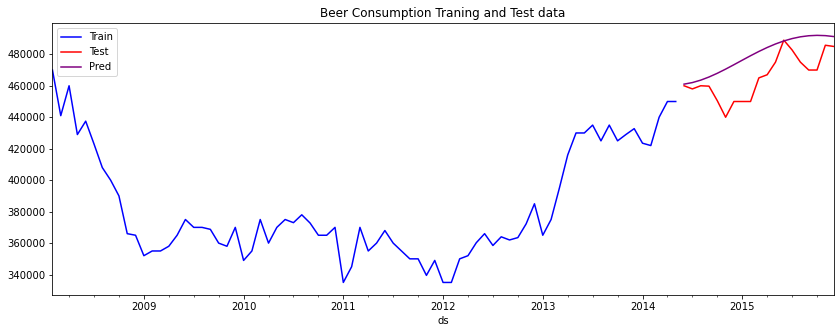

In [168]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
series_prophet_train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
series_prophet_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
pred.plot(kind='line', x='ds', y='y', color='purple', label='Pred', ax=ax)
plt.title('Beer Consumption Traning and Test data')
plt.show()

In [169]:
rmse_prophet = np.sqrt(skmetrics.mean_squared_error(series_prophet_test.y, pred.y))
rmse_prophet

16936.787904798177

In [170]:
# rmse_sarima1 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 1, 0), (0, 0, 0, 0))
# rmse_sarima2 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 0, 0, 0))
# rmse_sarima3 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 1, 2, 12))

rmse_sarima1, rmse_sarima2, rmse_sarima3

NameError: name 'rmse_sarima1' is not defined

In [171]:
# ARIMA(0, 1, 0) performs best so far

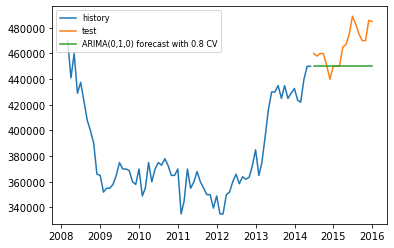

In [13]:
# 0.8 CV instead of one-step CV for ARIMA(0, 1, 0)
split = int(len(series_target.MedianSoldPrice_AllHomes_California)* 0.8)
train= series_target.MedianSoldPrice_AllHomes_California[0:split] 
test_1=series_target.MedianSoldPrice_AllHomes_California[split:]

mod = sm.tsa.statespace.SARIMAX(train,order=(0,1,0),seasonal_order=(0,0,0,0))
res = mod.fit()
pred = res.predict(start=len(train), end=len(train)+len(test_1)-1)

rmse_1 = np.sqrt(skmetrics.mean_squared_error(test_1, pred))

plt.plot(train, label='history')
plt.plot(test_1, label='test')
plt.plot(pred, label='ARIMA(0,1,0) forecast with 0.8 CV')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
rmse_1

20672.81140964981

In [15]:
# One step CV
X = series_target.MedianSoldPrice_AllHomes_California
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:]

predictions = list()
for t in tqdm(range(len(test))):
    model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=(0,1,0),seasonal_order=(0,0,0,0))
    model_fit = model.fit()
    yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
    predictions.append(yhat) #store prediction
    # calculate out of sample error
predictions = np.asarray(predictions).reshape(-1,)

predictions_1step = pd.Series(predictions, index=test.index)

rmse_1 = np.sqrt(skmetrics.mean_squared_error(test, predictions_1step))

100%|██████████| 19/19 [00:00<00:00, 53.67it/s]


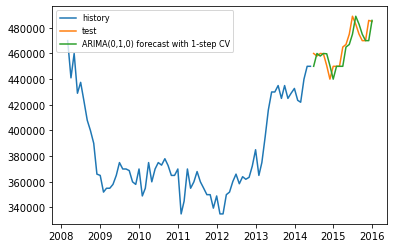

In [16]:
plt.plot(train, label='history')
plt.plot(test, label='test')
plt.plot(predictions_1step, label='ARIMA(0,1,0) forecast with 1-step CV')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
rmse_1

8161.607813737632